In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

import os
import torch

from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms.v2.functional import to_pil_image

from torchvision.io import read_image
from torchvision import transforms

import torch.optim as optim
import torch.nn as nn

from torchvision import models

In [2]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))


    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        
        img = read_image(img_path)
        mask = read_image(mask_path)

        obj_ids = torch.unique(mask)  # how many different colors encoded in this instances
        
        obj_ids = obj_ids[1:]  # Remove background
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks) # -----------> repurposing mask into bounding boxes

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
  
        image_id = idx
        
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Convert image to PIL Image
        img = to_pil_image(img)

        if self.transforms:
            img = self.transforms(img)

        target = {
            'boxes': boxes,
            'masks': masks,
            'labels': labels,
            'image_id': torch.tensor([image_id]),
            'area': area,
            'iscrowd': iscrowd,
        }

        return img, target

    def __len__(self):
        return len(self.imgs)

transform = transforms.Compose([transforms.ToTensor(),])

root = r'C:\Users\akilarasan.p\Downloads\PennFudanPed\PennFudanPed'
transform = transforms.Compose([transforms.ToTensor()])
dataset = PennFudanDataset(root=root, transforms=transform)

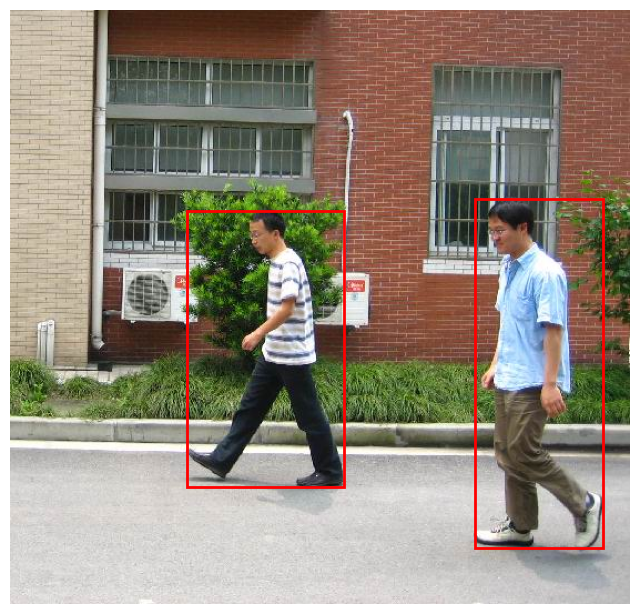

In [3]:
# Visualize a single image and its annotations
def visualize_sample(dataset, idx=0):
    img, target = dataset[idx]
    
    # Convert to PIL image for visualization
    img = F.to_pil_image(img)
    boxes = target['boxes'].to("cpu").numpy()  # Bounding boxes
    masks = target['masks'].to("cpu").numpy()  # Masks
    
    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    
    # Overlay bounding boxes
    for box in boxes:
        x1, y1, x2, y2 = box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                           fill=False, edgecolor='red', linewidth=2))
    
    plt.axis('off')
    plt.show()

visualize_sample(dataset, idx=0)


In [4]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a pre-trained Faster R-CNN model
def get_model(num_classes):
    # Load Faster R-CNN pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the head with a new one for our dataset
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [5]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Parameters
num_classes = 2  # Background + 1 object (person)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize model, dataset, and optimizer
model = get_model(num_classes).to(device)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for images, targets in data_loader:
        # Move data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    lr_scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/10, Loss: 19.9726
Epoch 2/10, Loss: 9.2528
Epoch 3/10, Loss: 7.4640
Epoch 4/10, Loss: 5.2858


KeyboardInterrupt: 

In [ ]:
# Set the model to evaluation mode
model.eval()

# Test with a single image
img, _ = dataset[0]  # Ignore target
with torch.no_grad():
    prediction = model([img.to(device)])[0]

# Visualize the results
visualize_detections(img, prediction)
# Set the model to evaluation mode
model.eval()

# Test with a single image
img, _ = dataset[0]  # Ignore target
with torch.no_grad():
    prediction = model([img.to(device)])[0]

# Visualize the results
visualize_detections(img, prediction)
